## The dataset we are working with is VoxCeleb1 dataset, an audio dataset of utterances from 1,251 different celebrities.
It is quite large.

In [1]:
from pathlib import Path

root_directory = Path('./data/wav')
bytes_to_gb = 10**(-9)
size = sum(f.stat().st_size for f in root_directory.glob('**/*') if f.is_file())
print('Size of VoxCeleb1 dataset:', str(size * bytes_to_gb), 'GB')

Size of VoxCeleb1 dataset: 39.220139292 GB


## We iterate over the VoxCeleb1 dataset, and for each audio file we will extract several features.
For some visualizations, consider the following sample audio file:

In [2]:
SAMPLE_AUDIO_PATH = './data/wav/id10001/1zcIwhmdeo4/00002.wav'

import librosa
import librosa.display as display
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings

warnings.filterwarnings('ignore')
sample_audio_file, sr = librosa.load(path=SAMPLE_AUDIO_PATH)
Audio(SAMPLE_AUDIO_PATH, rate=sr)

Before we dive in, we will be using quite a few external libraries:

In [3]:
import librosa
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import argparse
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import threading
import time
import tqdm

## Now, let's extract some features.

Tonnetz: lattice diagram representing tonal space

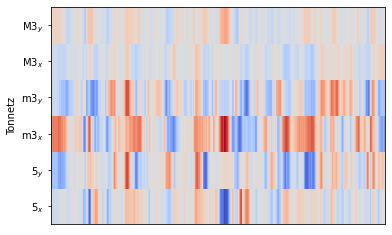

In [4]:
tonnetz = librosa.feature.tonnetz(sample_audio_file, sr)
display.specshow(data=tonnetz, y_axis='tonnetz')


Spectogram: visual representation of the frequencies of the signal over time

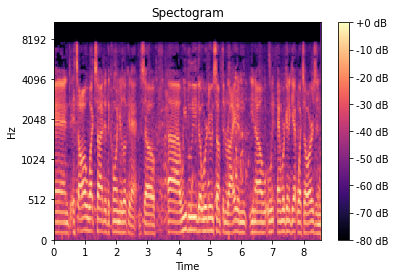

In [5]:
fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=sample_audio_file, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Spectogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

Pitches: how high or low the voices is, closely related to frequencies

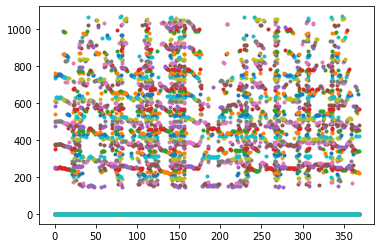

In [6]:
pitches, magnitudes = librosa.piptrack(y=sample_audio_file, sr=sr)
plt.plot(np.tile(np.arange(pitches.shape[1]), [100, 1]).T, pitches[:100, :].T, '.')
plt.show()

Tempogram: variation of tempo (pace) of the audio signal over time

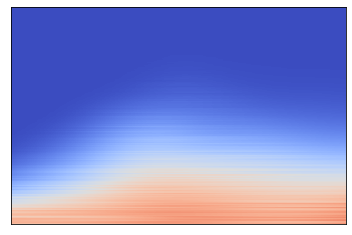

In [7]:
tempogram = librosa.feature.tempogram(sample_audio_file, sr)
display.specshow(tempogram, sr=sr)

MFCC: achieved by taking Fourier transform of the signal, applying log, then taking discrete cosine transform on the powers. 

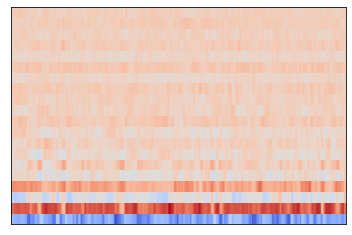

In [8]:
mfcc = librosa.feature.mfcc(sample_audio_file, sr)
display.specshow(mfcc, sr=sr)

Chroma STFT: variation of time frequency distribution, similar to spectogram for 12 pitch classes

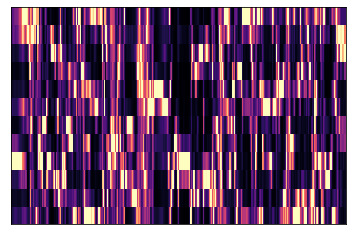

In [9]:
chroma_stft = librosa.feature.chroma_stft(sample_audio_file, sr)
display.specshow(chroma_stft, sr=sr)

## For every feature, we assign a weight: the weights can be played around with and achieved through trial and error:

In [10]:
MAX_TONNETZ_WEIGHT = 450
MAX_SPECTOGRAM_WEIGHT = 1000
MAX_TEMPOGRAM_WEIGHT = 300
MAX_CHROMA_WEIGHT = 400
MAX_MFCC_WEIGHT = 500
MAX_PITCH_WEIGHT = 500 

Next, we need to load the VoxCeleb dataset.

As we are dealing with a large dataset, we will process it with threads.

We will also limit the number of files we process for each speaker, and limit the number of speakers

In [11]:
class DatasetLoader:
    def __init__(self, num_threads=4, max_files_to_process_per_speaker=15, min_audio_file_duration=8, max_numbers_of_speakers=15):
        self.X = []
        self.Y = []
        self.threads = list()
        self.file_paths_to_process = list()
        self.num_threads = num_threads
        self.lock = threading.Lock()
        self.max_files_to_process_per_speaker = max_files_to_process_per_speaker
        self.progress = None
        self.min_audio_file_duration = min_audio_file_duration
        self.max_numbers_of_speakers = max_numbers_of_speakers

    def load_dataset(self, path):
        for dir in os.listdir(path):
            processed_count = 0
            if processed_count > self.max_files_to_process_per_speaker:
                continue
            if int(dir[2:]) > 10000 + self.max_numbers_of_speakers:
                return
            if os.path.isdir(path + '/' + dir):
                for inner_dir in os.listdir(path + '/' + dir):
                    if processed_count > self.max_files_to_process_per_speaker:
                        break
                    for audio_file_to_process in os.listdir(path + '/' + dir + '/' + inner_dir):
                        full_path = path + '/' + dir + '/' + inner_dir
                        if librosa.get_duration(librosa.load(full_path + '/' + audio_file_to_process, sr=None)[0]) < self.min_audio_file_duration:
                            continue
                        self.file_paths_to_process.append((full_path, audio_file_to_process,))
                        processed_count += 1
                        if processed_count > self.max_files_to_process_per_speaker:
                            break

    def process_dataset(self):
        split = np.array_split(self.file_paths_to_process, self.num_threads)
        print('processing dataset with {0} threads and {1} total audio files'.format(self.num_threads, len(self.file_paths_to_process)))
        self.progress = tqdm.tqdm(total=len(self.file_paths_to_process), desc='Extracting features from audio')

        with self.progress:
            for i in range(self.num_threads):
                t = threading.Thread(target=self.process_audio_files_array, args=([split[i]]))
                self.threads.append(t)
                t.start()
            for t in self.threads:
                t.join()

    def load_and_process_dataset(self, path):
        self.load_dataset(path)
        start = time.time()
        self.process_dataset()
        end = time.time()
        print('finished processing dataset in {:.3f} ms'.format(end - start))
        return self

    def process_audio_files_array(self, arr):
        for filepath, filename in arr:
            self.process_audio_file(filepath, filename)

    def process_audio_file(self, filepath, filename: str):
        label = filepath.split('/')[-2]
        features = self.extract_features(filepath, filename)
        self.lock.acquire()
        self.X.append(features)
        self.Y.append(label)
        self.progress.update(1)
        self.lock.release()

    def extract_features(self, filepath, filename):
        full_path = filepath + '/' + filename
        if not os.path.isfile(full_path):
            raise Exception('invalid path: ' + full_path)
        samples, sample_rate = librosa.load(full_path, sr=None, duration=5)
        tonnetz = librosa.feature.tonnetz(y=samples, sr=sample_rate)
        chroma_stft = librosa.feature.chroma_stft(y=samples, sr=sample_rate)
        tempogram = librosa.feature.tempogram(y=samples, sr=sample_rate)
        spectogram = librosa.feature.melspectrogram(samples, sample_rate)
        mfcc = librosa.feature.mfcc(y=samples, sr=sample_rate)
        pitches, magnitudes = librosa.piptrack(y=samples, sr=sample_rate)
        return np.concatenate([tonnetz.flatten()[:MAX_TONNETZ_WEIGHT], spectogram.flatten()[:MAX_SPECTOGRAM_WEIGHT],
                               tempogram.flatten()[:MAX_TEMPOGRAM_WEIGHT],
                               chroma_stft.flatten()[:MAX_CHROMA_WEIGHT],
                               mfcc.flatten()[:MAX_MFCC_WEIGHT], magnitudes.flatten()[:MAX_PITCH_WEIGHT]])

After loading the dataset, we need a classifier - formally, a function from the domain of extracted audio samples features to the domain of labels.

We try out the followings classifiers:

- KNN: classify according to majority of nearest neighbors according to Euclidean distance
- SVM: the classifier is a line that achieves the largest separating margin, found by solving a linear set of equations with constraints. Two types of kernel are tested out.
- DT: a tree is grown such that every node is split according to some feature, and the leaves hold the decisions
- NN: a deep neural network
- Bayes: using Bayes theorem to solve the conditional probability for the output given the input 
- AdaBoost: iterative algorithm that trains an ensemble of weak learners, such that high weights are given to incorrect predictions

The classifier is outputted from the function below:

In [12]:
CLASSIFIERS = ['knn', 'linear_svm', 'poly_svm', 'rbf', 'dt', 'nn', 'bayes', 'ada']

def get_classifier(classifier):
    if classifier not in CLASSIFIERS:
        raise Exception('No classifier found!!')
    print('Classifier used :', classifier)
    if classifier == 'knn':
        return KNeighborsClassifier(n_neighbors=1)
    if classifier == 'linear_svm':
        return SVC(kernel='linear')
    if classifier == 'poly_svm':
        return SVC(kernel='poly')
    if classifier == 'rbf':
        return SVC(kernel='rbf')
    if classifier == 'dt':
        return DecisionTreeClassifier()
    if classifier == 'nn':
        return MLPClassifier()
    if classifier == 'bayes':
        return GaussianNB()
    if classifier == 'ada':
        return AdaBoostClassifier()

After we have a classifier, we want to test its accuracy on the test dataset:

In [13]:
def test_accuracy(X, Y, classifier):
    err = 0
    prediction = classifier.predict(X)
    for i in range(len(prediction)):
        y, pred = Y[i], prediction[i]
        print('model predicted:', pred, 'actual label:', y)
        if pred != y:
            err += 1
    return 1 - (err / len(X))

The entire flow happens in the main, where we check out every classifier and compare the accuracy.

The dataset we loaded is split such that 33% of it is used for testing, and the rest for training.

In [14]:
def main():
    train_path = 'data/wav'
    dataset_loader = DatasetLoader()
    dataset_loader.load_and_process_dataset(train_path)
    assert len(dataset_loader.X) == len(dataset_loader.Y)
    X_train, X_test, y_train, y_test = train_test_split(
        dataset_loader.X, dataset_loader.Y, test_size=0.33, random_state=42)
    for classifier in CLASSIFIERS:
        c = get_classifier(classifier)
        c.fit(X_train, y_train)
        acc = test_accuracy(X_test, y_test, c)
        print('Accuracy achieved {:.3f}'.format(acc), 'with classifier {0}'.format(classifier))


if __name__ == '__main__':
    main()

Extracting features from audio:   0%|                                                                                                                                                | 0/186 [00:00<?, ?it/s]

processing dataset with 4 threads and 186 total audio files


Extracting features from audio: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [03:02<00:00,  1.02it/s]


finished processing dataset in 182.064 ms
Classifier used : knn
model predicted: id10001 actual label: id10011
model predicted: id10004 actual label: id10008
model predicted: id10005 actual label: id10015
model predicted: id10014 actual label: id10007
model predicted: id10014 actual label: id10003
model predicted: id10009 actual label: id10008
model predicted: id10005 actual label: id10015
model predicted: id10006 actual label: id10006
model predicted: id10014 actual label: id10007
model predicted: id10013 actual label: id10007
model predicted: id10008 actual label: id10001
model predicted: id10010 actual label: id10010
model predicted: id10014 actual label: id10007
model predicted: id10014 actual label: id10014
model predicted: id10013 actual label: id10013
model predicted: id10010 actual label: id10001
model predicted: id10014 actual label: id10014
model predicted: id10014 actual label: id10008
model predicted: id10005 actual label: id10004
model predicted: id10005 actual label: id10

model predicted: id10006 actual label: id10011
model predicted: id10004 actual label: id10008
model predicted: id10004 actual label: id10015
model predicted: id10006 actual label: id10007
model predicted: id10004 actual label: id10003
model predicted: id10004 actual label: id10008
model predicted: id10004 actual label: id10015
model predicted: id10006 actual label: id10006
model predicted: id10001 actual label: id10007
model predicted: id10001 actual label: id10007
model predicted: id10006 actual label: id10001
model predicted: id10006 actual label: id10010
model predicted: id10001 actual label: id10007
model predicted: id10004 actual label: id10014
model predicted: id10001 actual label: id10013
model predicted: id10006 actual label: id10001
model predicted: id10001 actual label: id10014
model predicted: id10012 actual label: id10008
model predicted: id10004 actual label: id10004
model predicted: id10004 actual label: id10005
model predicted: id10001 actual label: id10006
model predict

model predicted: id10001 actual label: id10011
model predicted: id10011 actual label: id10008
model predicted: id10001 actual label: id10015
model predicted: id10001 actual label: id10007
model predicted: id10002 actual label: id10003
model predicted: id10011 actual label: id10008
model predicted: id10001 actual label: id10015
model predicted: id10006 actual label: id10006
model predicted: id10008 actual label: id10007
model predicted: id10007 actual label: id10007
model predicted: id10001 actual label: id10001
model predicted: id10001 actual label: id10010
model predicted: id10014 actual label: id10007
model predicted: id10004 actual label: id10014
model predicted: id10004 actual label: id10013
model predicted: id10001 actual label: id10001
model predicted: id10003 actual label: id10014
model predicted: id10004 actual label: id10008
model predicted: id10004 actual label: id10004
model predicted: id10014 actual label: id10005
model predicted: id10006 actual label: id10006
model predict